In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import platform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest        # 이상치 판별을 위한 Isolation Forest 모델

In [120]:
### matplotlib 에서 한글 및 음수 표현이 깨지는 현상 수정

system = platform.system()

if system == "Windows":     # Windows
    rcParams['font.family'] = 'Malgun Gothic'
elif system == "Darwin":    # macOS
    rcParams['font.family'] = 'AppleGothic'

rcParams['axes.unicode_minus'] = False

In [121]:
### 데이터 체크 클래스 선언

class DataCheck() :
    
    # 생성 시 기존 데이터를 넣어둠
    def __init__(self, df) :
        self.raw_df = df
    
    # continuous한 컬럼과 categorical한 컬럼을 반환
    @staticmethod
    def return_cols(df, type, boundary=15) :    # type : ('continuous', 'categorical'), boundary : 두 분류를 결정할 서로 다른 요소의 수
        cols = []
        if type == 'continuous' :
            for col in df.columns:
                if df[col].nunique(dropna=True) >= boundary :
                    cols.append(col)
        elif type == 'categorical' :
            for col in df.columns:
                if df[col].nunique(dropna=True) < boundary :
                    cols.append(col)
        else :
            ValueError('Wrong type.')

        return cols
    
    # 정보 출력
    def print_info(self, df = None) :
        if df is None :         # 데이터를 전달하지 않으면 기존 데이터를 활용
            df = self.raw_df

        print('------ Data Info -----')
        df.info()
        print('\n----- Data Describe -----')
        display(df.describe())

    # 각 컬럼들의 값 출력
    def print_value_counts(self, df = None) :
        if df is None :         # 데이터를 전달하지 않으면 기존 데이터를 활용
            df = self.raw_df
        
        for col in df.columns:
            if df[col].nunique(dropna=True) > 15 :  # 각기 다른 값이 15개 이상인 Continuous 한 값들은 출력하지 않음
                print(col)
                print('continuous')
                print("-"*20)
                continue

            value_counts = df[col].fillna("NA").value_counts(dropna=False)  # 결측치는 NA로 처리 후 출력
            print(value_counts)
            print("-" * 20)

    # 데이터 to csv
    def save_to_csv(self, df):
        df.to_csv('Tree_Data_processing.csv', index=False)
    

In [ ]:
### 데이터 정제 클래스 선언

class DataModify () :
    
    # SMOTE 사용한 데이터 오버 샘플링
    @staticmethod
    def data_oversampling(df) :
        """
            oversampling 코드 구현
        """
        pass
    
    # 인코딩되기 전의 데이터에서 이상치를 제거
    @staticmethod
    def data_anomaly_del(df, return_anomaly=False) :
        df_cleaned = df.copy()
        df_anomaly = pd.DataFrame(columns=['Index', 'Column', 'Value'])

        # Alive == 'O' 행 처리
        alive_mask = df_cleaned['Alive'] == 'O'
        if alive_mask.any():
            alive_indices = df_cleaned.index[alive_mask]
            alive_rows = pd.DataFrame({
                'Index': alive_indices,
                'Column': 'Alive',
                'Value': 'O'
            })
            df_anomaly = pd.concat([df_anomaly, alive_rows], ignore_index=True)
            df_cleaned = df_cleaned[~alive_mask]

        # Phenolics, NSC, Lignin 음수값 처리
        cols = ["Phenolics", "NSC", "Lignin"]
        df_negatives = df_cleaned[cols].copy()
        df_neg_long = df_negatives.stack().reset_index()
        df_neg_long = df_neg_long.rename(columns={'level_0':'Index', 'level_1':'Column', 0:'Value'})
        df_neg_long = df_neg_long[df_neg_long['Value'] < 0]
        
        df_anomaly = pd.concat([df_anomaly, df_neg_long[['Index','Column','Value']]], ignore_index=True)

        df_cleaned['Phenolics'] = df_cleaned['Phenolics'] - df_cleaned['Phenolics'].min()
        

        if return_anomaly is True :
            return df_cleaned, df_anomaly
        else :
            return df_cleaned
    
    # 특성과 라벨, 훈련 데이터와 테스트 데이터를 분리하여 세트로 반환
    @staticmethod
    def split_feature_label(df, test_size=.2) :
        X = df.drop(columns='Alive')
        y = df['Alive']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        return [X_train, y_train], [X_test, y_test]     # train set과 test set을 반환
    
    # feature 데이터 스케일링
    @staticmethod
    def scale_data(train_set, test_set) :

        X_train = train_set[0]
        X_test = test_set[0]

        continuous_cols = DataCheck.return_cols(train_set, 'continuous')
        
        scaler = StandardScaler()

        X_train_scaled = X_train.copy()
        X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
        train_set_scaled = [X_train_scaled, train_set[1]]

        X_test_scaled = X_test.copy()
        X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])
        test_set_scaled = [X_test_scaled, test_set[1]]

        return train_set_scaled, test_set_scaled   # 값의 종류가 15개가 넘는, continuous 하고 숫자를 가지는 값들만 scaled
        

In [123]:
### 데이터 전처리 클래스 선언

class DataPreprocessing () :

    def __init__(self, df) :
        self.raw_df = df        # 수정 전 기본 데이터
        self.df = df            # 수정할 데이터
        self.categories = {}    # 인코딩한 카테고리
        self.drop_cols = []

    # 드랍할 컬럼을 설정
    def set_drop_cols(self, cols):
        self.drop_cols = cols

    # 수정 전의 데이터를 불러옴
    def call_raw_data(self) :
        return self.raw_df
    
    # 수정된 상태의 데이터를 불러옴, 데이터를 나누지 않은 상태로 불러옴
    def call_full_data(self) :
        return self.df
    
    # 데이터 드랍
    def drop_data(self, columns=None) :
        self.df = self.df.drop(columns=columns)
    
    # 결측치 처리
    def fill_na(self) :
        self.df['Harvest'] = self.df['Harvest'].fillna('O') # Harvest는 Binary 한 값
        self.df['Alive'] = self.df['Alive'].fillna('O')     # Alive는 Binary 한 값
        self.df['EMF'] = self.df['EMF'].fillna(0)           # EMF는 균의 비율로, 측정되지 않은 데이터는 균이 없는 것으로 추정

    # categorical한 데이터 encoding
    def category_encoding(self, encoding='label') :
        # encoding : 'label' - 라벨 인코딩, 'onehot' - One-hot 인코딩
        # categories = {'encoding_type':..., '컬럼명':{'요소':'라벨', '요소':'라벨', ...}, ...}
        # categorical한 데이터 = 데이터가 가지는 서로 다른 값이 15개 미만

        categorical_col = DataCheck.return_cols(self.df, 'categorical')       # Categorical한 column의 컬럼명을 선택

        df_encoded = self.df.copy() # 인코딩할 데이터

        if encoding == 'label' : # 라벨 형식으로 인코딩
            self.categories['encoding_type'] = 'label'

            for col in categorical_col:
                unique_vals = df_encoded[col].unique()
                label = {val: i for i, val in enumerate(unique_vals)}
                df_encoded[col] = df_encoded[col].map(label)
                self.categories[col] = label

        elif encoding == 'onehot' : # One-hot 인코딩
            self.categories['encoding_type'] = 'onehot'
            
            for col in categorical_col:
                dummies = pd.get_dummies(df_encoded[col], prefix=col)
                df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
                self.categories[col] = dummies.columns.tolist()

        else:   # 이상한 값이 들어오면 Value Error 발생
            raise ValueError(f"알 수 없는 encoding_type: {encoding}")

        return df_encoded   # 인코딩된 데이터를 반환
    
    # encoding된 데이터 decoding
    def category_decoding(self, df = None, categories=None) :
        if df is None :                 # 넣어준 인자가 없다면 기존 인스턴스에 저장된 데이터를 디코딩 수행
            df_decoded = self.df.copy()
        else:                           # 넣어준 인자가 있다면 넣어준 데이터에 대해 디코딩 수행
            df_decoded = df.copy()

        if categories is not None :
            self.categories = categories

        encoding_type = self.categories.get('encoding_type', None)  # categories 데이터에 저장된 인코딩 타입에 따라 인코딩 타입 설정

        if encoding_type == 'label':    # 라벨 인코딩일 경우
            for col, mapping in self.categories.items():
                if col == 'encoding_type':
                    continue
                # {원본값: 숫자} → {숫자: 원본값}
                reverse_map = {v: k for k, v in mapping.items()}
                df_decoded[col] = df_decoded[col].map(reverse_map)

        elif encoding_type == 'onehot': # One-hot 인코딩일 경우
            for col, dummy_cols in self.categories.items():
                if col == 'encoding_type':
                    continue
                # 각 mapping column 에서 값이 True인 행을 찾아 역으로 mapping
                def decode_row(row):
                    for dummy_col in dummy_cols:
                        if row[dummy_col] == 1:
                            return dummy_col.replace(f"{col}_", "")
                    return None
                
                df_decoded[col] = df_decoded.apply(decode_row, axis=1)
                df_decoded = df_decoded.drop(columns=dummy_cols)

        else:
            raise ValueError(f"알 수 없는 encoding_type: {encoding_type}")

        return df_decoded           # dictionary 형태 categories 를 받아서, 해당 데이터를 기반으로 디코딩 후, 테이블 반환
    
    # 날짜 기재 방식 통일
    def set_date(self):
        def date_modify(x):
            x = str(x)
            if '/' in x:
                return x.split('/')[0]
            else:
                return x 
        self.df['PlantDate'] = self.df['PlantDate'].apply(date_modify)
    
    # 생존, 실험 중단(수확), 사망 이벤트 -> label data로 병합
    def merge_label(self) :
        # Event가 NULL인 데이터는 pred_data로 따로 저장
        self.df.loc[self.df["Event"] == 1, "Alive"] = 0
        self.df.loc[self.df["Harvest"] == 'X', "Alive"] = 1
        self.df.loc[self.df["Alive"] == 'X', "Alive"] = 2

        self.df.drop(columns=['Event','Harvest'], inplace=True)

        return    # Event, Harvest, Alive를 병합하여 Dead, Harvest, Alive 3개의 카테고리로 분류
    
    # 전처리 과정 일괄 수행 (encoding은 선택)
    def run(self, encoding=None) :

        self.drop_data(self.drop_cols)
        
        self.fill_na()
        self.set_date()
        self.merge_label()

        if encoding is not None :       # 데이터를 인코딩
            self.df = self.category_encoding(encoding)

        return self.df
        

In [ ]:
### 데이터 시각화 클래스 선언

class DataVisualize () :

    # 생성 시 기존 데이터를 넣어둠
    def __init__(self, df) :
        self.raw_df = df

    # 연속형 값을 가지는 변수들에 대하여 boxplot을 출력
    def show_boxplot_for_continuous_value(self, df=None) :
        if df is None:
            df = self.raw_df
        
        columns = DataCheck.return_cols(df, 'continuous')

        df_melt = df[columns].melt(var_name="특성", value_name="값")

        plt.figure(figsize=(1.5*len(columns), 6))
        sns.boxplot(x="특성", y="값", data=df_melt)
        plt.title("특성별 값의 분포")
        plt.xticks(rotation=45)
        plt.show()

    # isolation forest 모델을 사용하여 이상치가 있는지, 이상치 점수 분포를 만들고 시각화
    def show_anomaly_score(self, series) :
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        
        # 모델 학습 (Series를 2D 배열로 변환)
        X = series.values.reshape(-1, 1)
        iso_forest.fit(X)
        
        # decision function 점수 계산
        scores = iso_forest.decision_function(X)
        
        # 점수 분포 시각화
        plt.figure(figsize=(10,6))
        sns.histplot(scores, bins=50, kde=True, color='skyblue')
        plt.axvline(x=0, color='red', linestyle='--', label='Threshold (0)')
        plt.title(f'Isolation Forest Decision Function Scores')
        plt.xlabel('Decision Function Score')
        plt.ylabel('Count')
        plt.legend()
        plt.show()
        
        # Series 형태로 반환
        return pd.Series(scores, index=series.index, name='IF_score')
    
    # 연속적인 값들을 기반으로 correlation 히트맵 출력
    def show_heatmap_for_continuous_value(self, df=None):
        if df is None:
            df = self.raw_df

        # 숫자형 컬럼만 선택
        numeric_df = df.select_dtypes(include=["int64", "float64"])

        # 상관계수 계산
        corr = numeric_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title("Correlation Heatmap", fontsize=16)
        plt.show()

    # 컬럼 값을 기준으로 누적 막대 그래프 출력
    def show_survival_ratio(self, df, col):
        # Alive 상태별 비율 계산
        ratio_df = df.groupby(col)['Alive'].value_counts(normalize=True).unstack(fill_value=0)

        # 누적 막대 그래프 그리기
        ratio_df.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')

        plt.title(f"{col} 특성별 생존율")
        plt.xlabel(col)
        plt.ylabel("비율(%)")
        plt.ylim(0,1)
        plt.legend(["Dead", "Harvested", "Alive"], title="Alive", bbox_to_anchor=(1.05,1), loc='upper left')
        plt.show()

    # 연속값을 가지는 컬럼에서 특정값을 기준값으로 하여 누적 막대 그래프 출력
    def show_survival_ratio_with_threshold(self, df, col, threshold) :
        group_col = f"{col}_group"
        df[group_col] = df[col].apply(lambda x: f">={threshold}" if x >= threshold else f"<{threshold}")
        
        # Alive 상태 비율 계산
        ratio_df = df.groupby(group_col)['Alive'].value_counts(normalize=True).unstack().fillna(0)
        
        # 그래프 그리기
        plt.figure(figsize=(6,6))
        ratio_df.plot(kind='bar', stacked=True, colormap="Set2")

        plt.title(f"{col} 기준 {threshold}에 따른 Alive 상태 비율")
        plt.xlabel(f"{col} Group")
        plt.ylabel("비율")
        plt.ylim(0,1)
        plt.legend(["Dead", "Harvested", "Alive"], title="Alive", bbox_to_anchor=(1.05,1), loc='upper left')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    # 시간에 따라 나무 상태의 변화를 나타낸 그래프 출력
    def show_alive_about_time(self, df):
        # 정렬된 Time 목록
        time_points = np.sort(df['Time'].unique())
        
        # 초기 상태: 모든 샘플 Alive=2
        alive_counts = pd.DataFrame({
            'Time': [0],
            0: [0],   # Dead
            1: [0],   # Harvested
            2: [len(df)]  # Alive
        })

        for t in time_points:
            prev = alive_counts.iloc[-1][[0,1,2]].values
        
            current_dead = df[(df['Time']==t) & (df['Alive']==0)].shape[0]
            current_harvest = df[(df['Time']==t) & (df['Alive']==1)].shape[0]
            current_alive = df[(df['Time']==t) & (df['Alive']==2)].shape[0]

            new_counts = [
                prev[0] + current_dead,
                prev[1] + current_harvest,
                prev[2] - (current_dead + current_harvest)
            ]

            alive_counts = pd.concat([alive_counts, pd.DataFrame([[t]+new_counts], columns=['Time',0,1,2])], ignore_index=True)

        plt.figure(figsize=(10,6))
        plt.plot(alive_counts['Time'], alive_counts[0], label='Dead', color='red')
        plt.plot(alive_counts['Time'], alive_counts[1], label='Harvested', color='orange')
        plt.plot(alive_counts['Time'], alive_counts[2], label='Alive', color='green')

        plt.xlabel("Time")
        plt.ylabel("샘플 수")
        plt.title("시간에 따른 나무의 상태")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # 토양의 출처 종과 실제 종 사이의 생존율 그래프 출력
    def show_survival_heatmap_by_soil(self, df):

        # 생존율 계산
        heatmap_data = (
            df[df['Alive'].isin([0,2])]                 # 라벨 1 제거
            .groupby(['Soil', 'Species'])['Alive']
            .apply(lambda x: (x==2).mean())           # 생존(2)의 비율
            .unstack()
        )
        
        plt.figure(figsize=(10,6))
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            cbar_kws={'label':'Survival Rate'}
        )
        plt.title("토양 출처와 종에 따른 생존율")
        plt.xlabel("종")
        plt.ylabel("토양의 출처가 되는 종")
        plt.show()

    # 내재 화합물에 대한 히스토그램 출력
    def show_chemical_histogram(self, df, col):
        plt.figure(figsize=(7, 4))
        sns.histplot(data=df, x=col, bins=30, kde=True)
        plt.title(f"{col}")
        plt.xlabel(col)
        plt.ylabel("Samples")  
        plt.tight_layout()
        plt.show()

    # 내재 화합물 간의 관계를 파악하기 위한 산점도 출력
    def show_chemical_relation_scatter(self, df, versus) :
        for x, y in versus:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(data=df, x=x, y=y, edgecolor='black', hue=x)
            plt.title(f"{y} vs {x}")
            plt.xlabel(x)
            plt.ylabel(y)
            plt.tight_layout()
            plt.show()

    # 내재 화합물 간의 관계를 생존율 관련 boxplot으로 출력
    def show_chemical_relation_by_survive(self, df) :
        columns = ['Phenolics', 'Lignin', 'NSC']

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

        for i, col in enumerate(columns):
            sns.boxplot(
                data=df,
                x='Alive',      
                y=col,                
                ax=axes[i]            
            )
            axes[i].set_title(f"생존과 {col}의 관계성")
            axes[i].set_xlabel("생존")
            axes[i].set_ylabel(col)

        plt.tight_layout()
        plt.show()

    # 균 타입별 분포를 히트맵으로 출력
    def show_hitmap_by_Myco(self, df) :

        # 교차표
        crosstab = pd.crosstab(df['Myco'], df['SoilMyco'])

        # 인코딩된 정보가 들어왔을 경우
        if pd.api.types.is_integer_dtype(df['Myco']) :
            # 라벨 맵핑
            myco_map = {0: "AMF (묘목)", 1: "EMF (묘목)"}
            soilmyco_map = {0: "AMF (토양)", 1: "EMF (토양)", 2: "기타/살균 (토양)"}
            # 행/열 라벨 바꾸기
            crosstab.index = crosstab.index.map(myco_map)
            crosstab.columns = crosstab.columns.map(soilmyco_map)

        # heatmap 시각화
        plt.figure(figsize=(9,4))
        sns.heatmap(
            crosstab, 
            annot=True, 
            fmt="d", 
            cmap="YlGnBu",
            # linewidths=1,
            linecolor='black',
            cbar_kws={'label': '빈도수'}
        )
        plt.title("Myco (묘목) vs SoilMyco (토양) 교차표", fontsize=14, fontweight='bold')
        plt.xlabel("SoilMyco", fontsize=12)
        plt.ylabel("Myco", fontsize=12)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)
        plt.tight_layout()
        plt.show()

In [125]:
### 데이터 로드

input_file_path = './data/Tree_data.csv'

df = pd.read_csv(input_file_path)

### 인스턴스 생성

dc = DataCheck(df)
dp = DataPreprocessing(df)
dv = DataVisualize(df)

In [126]:
# 정보 출력

dc.print_info(df)

------ Data Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           2783 non-null   int64  
 1   Plot         2783 non-null   int64  
 2   Subplot      2783 non-null   object 
 3   Species      2783 non-null   object 
 4   Light_ISF    2783 non-null   float64
 5   Light_Cat    2783 non-null   object 
 6   Core         2783 non-null   int64  
 7   Soil         2783 non-null   object 
 8   Adult        2783 non-null   object 
 9   Sterile      2783 non-null   object 
 10  Conspecific  2783 non-null   object 
 11  Myco         2783 non-null   object 
 12  SoilMyco     2783 non-null   object 
 13  PlantDate    2783 non-null   object 
 14  AMF          2783 non-null   float64
 15  EMF          1283 non-null   float64
 16  Phenolics    2783 non-null   float64
 17  Lignin       2783 non-null   float64
 18  NSC          2783 non-nul

,No,Plot,Light_ISF,Core,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,1283.00000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2782.000000
mean,3914.513834,9.561624,0.085707,2016.648940,20.553069,26.47675,1.933105,15.759792,14.219641,15.282070,53.487244,0.570453
std,2253.515063,5.203659,0.025638,0.477387,12.309587,16.63689,1.969842,6.779607,4.298271,9.166555,32.082942,0.495100
min,3.000000,1.000000,0.032000,2016.000000,0.000000,0.00000,-1.350000,2.230000,4.300000,4.000000,14.000000,0.000000
25%,1971.000000,5.000000,0.066000,2016.000000,13.400000,13.78000,0.170000,10.355000,11.605000,7.000000,24.500000,0.000000
50%,3932.000000,10.000000,0.082000,2017.000000,18.000000,27.72000,0.750000,14.040000,12.660000,13.000000,45.500000,1.000000
75%,5879.000000,14.000000,0.100000,2017.000000,24.445000,35.71000,3.780000,21.115000,17.275000,18.000000,63.000000,1.000000
max,7772.000000,18.000000,0.161000,2017.000000,100.000000,87.50000,6.100000,32.770000,29.450000,33.000000,115.500000,1.000000


In [127]:
# 컬럼값 출력

dc.print_value_counts(df)

No
continuous
--------------------
Plot
continuous
--------------------
Subplot
A    701
D    666
B    663
C    646
E    107
Name: count, dtype: int64
--------------------
Species
Acer saccharum     751
Prunus serotina    749
Quercus alba       673
Quercus rubra      610
Name: count, dtype: int64
--------------------
Light_ISF
continuous
--------------------
Light_Cat
Med     1474
Low     1005
High     304
Name: count, dtype: int64
--------------------
Core
2017    1806
2016     977
Name: count, dtype: int64
--------------------
Soil
Sterile                  423
Prunus serotina          413
Quercus rubra            402
Acer saccharum           397
Populus grandidentata    391
Quercus alba             381
Acer rubrum              376
Name: count, dtype: int64
--------------------
Adult
continuous
--------------------
Sterile
Non-Sterile    2360
Sterile         423
Name: count, dtype: int64
--------------------
Conspecific
Heterospecific    1974
Sterilized         423
Conspecific        

In [128]:
# 이상치 확인

print(df[df['Event'].isna()])

        No  Plot Subplot       Species  Light_ISF Light_Cat  Core     Soil  \
2781  7771    18       D  Quercus alba      0.161      High  2017  Sterile   

     Adult  Sterile  ...    AMF    EMF Phenolics Lignin    NSC  Census   Time  \
2781  1297  Sterile  ...  16.99  22.51      4.28  19.38  21.36      33  115.5   

      Event  Harvest  Alive  
2781    NaN      NaN    NaN  

[1 rows x 24 columns]


In [129]:
### 드랍할 컬럼 설정
drop_cols = ['No', 'Plot', 'Adult', 'Subplot', 'Core', 'Census']
dp.set_drop_cols(drop_cols)

encode = dp.run(encoding='label')
display(encode)

,Species,Light_ISF,Light_Cat,Soil,Sterile,Conspecific,Myco,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Time,Alive
0,0,0.106,0,0,0,0,0,0,0,22.00,0.00,-0.56,13.86,12.15,14.0,0
1,1,0.106,0,1,0,0,1,1,1,15.82,31.07,5.19,20.52,19.29,115.5,1
2,2,0.106,0,0,0,0,1,0,1,24.45,28.19,3.36,24.74,15.01,63.0,0
3,0,0.080,0,0,0,0,0,0,0,22.23,0.00,-0.71,14.29,12.36,14.0,0
4,0,0.060,1,0,0,0,0,0,0,21.15,0.00,-0.58,10.85,11.20,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,3,0.111,0,3,0,0,0,1,0,40.89,0.00,0.83,9.15,11.88,56.0,0
2779,1,0.118,0,2,0,0,1,0,1,15.47,32.82,4.88,19.01,23.50,56.0,0
2780,1,0.118,0,1,0,0,1,1,1,11.96,37.67,5.51,21.13,19.10,56.0,0
2781,1,0.161,2,4,1,1,1,2,1,16.99,22.51,4.28,19.38,21.36,115.5,3


In [130]:
display(dp.category_decoding(encode))
decode = dp.category_decoding(encode)
decode = DataModify.data_anomaly_del(decode)

,Species,Light_ISF,Light_Cat,Soil,Sterile,Conspecific,Myco,SoilMyco,PlantDate,AMF,EMF,Phenolics,Lignin,NSC,Time,Alive
0,Acer saccharum,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6,22.00,0.00,-0.56,13.86,12.15,14.0,0
1,Quercus alba,0.106,Med,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,5,15.82,31.07,5.19,20.52,19.29,115.5,2
2,Quercus rubra,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,EMF,AMF,5,24.45,28.19,3.36,24.74,15.01,63.0,0
3,Acer saccharum,0.080,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6,22.23,0.00,-0.71,14.29,12.36,14.0,0
4,Acer saccharum,0.060,Low,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,6,21.15,0.00,-0.58,10.85,11.20,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,Prunus serotina,0.111,Med,Populus grandidentata,Non-Sterile,Heterospecific,AMF,EMF,6,40.89,0.00,0.83,9.15,11.88,56.0,0
2779,Quercus alba,0.118,Med,Acer rubrum,Non-Sterile,Heterospecific,EMF,AMF,5,15.47,32.82,4.88,19.01,23.50,56.0,0
2780,Quercus alba,0.118,Med,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,5,11.96,37.67,5.51,21.13,19.10,56.0,0
2781,Quercus alba,0.161,High,Sterile,Sterile,Sterilized,EMF,Sterile,5,16.99,22.51,4.28,19.38,21.36,115.5,O


##### 시각화
- 인코딩된 데이터 : encode
- 시각화 할때 쓸 인코딩 되기 전의 데이터 : decode

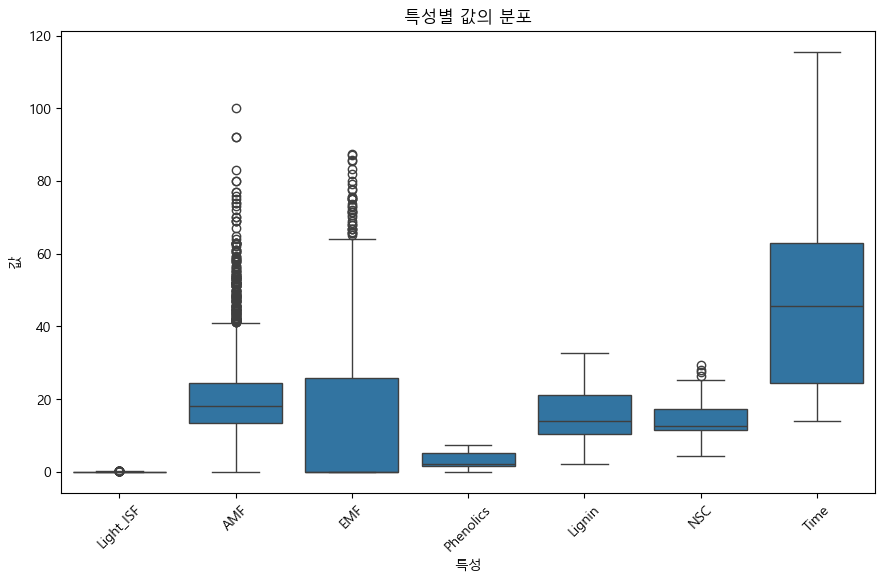

In [131]:
dv.show_boxplot_for_continuous_value(decode)

In [132]:
_, anomaly = DataModify.data_anomaly_del(decode, return_anomaly=True)

display(anomaly)

,Index,Column,Value


<class 'pandas.core.frame.DataFrame'>


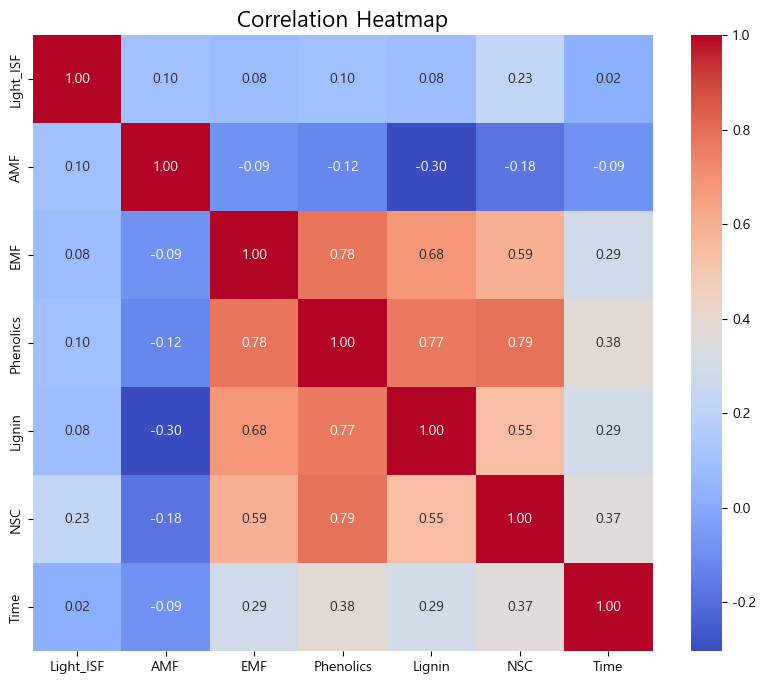

In [133]:
print(type(decode))
dv.show_heatmap_for_continuous_value(decode)

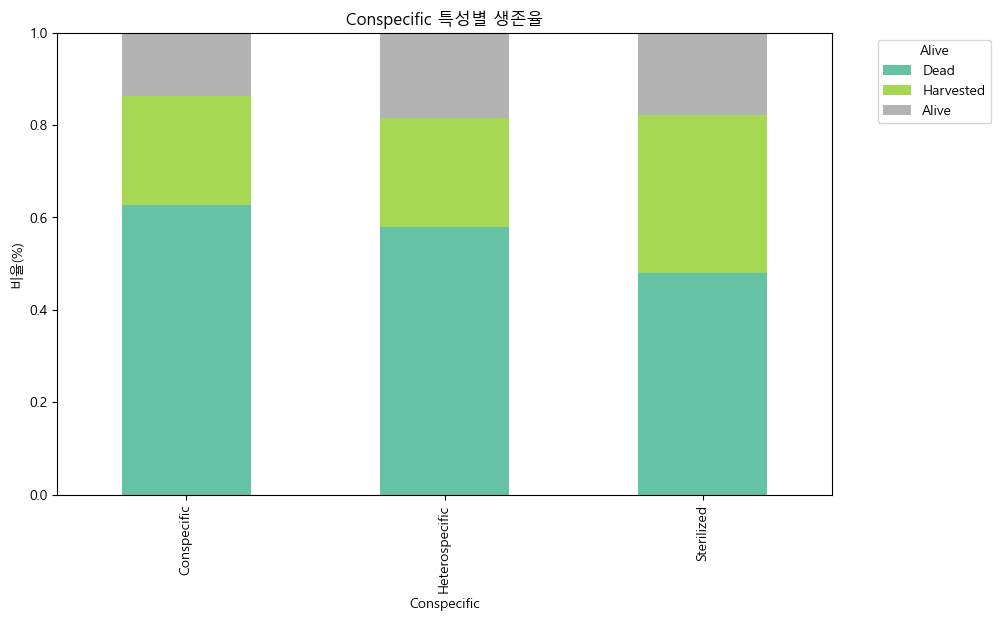

In [141]:
dv.show_survival_ratio(decode, 'Conspecific')

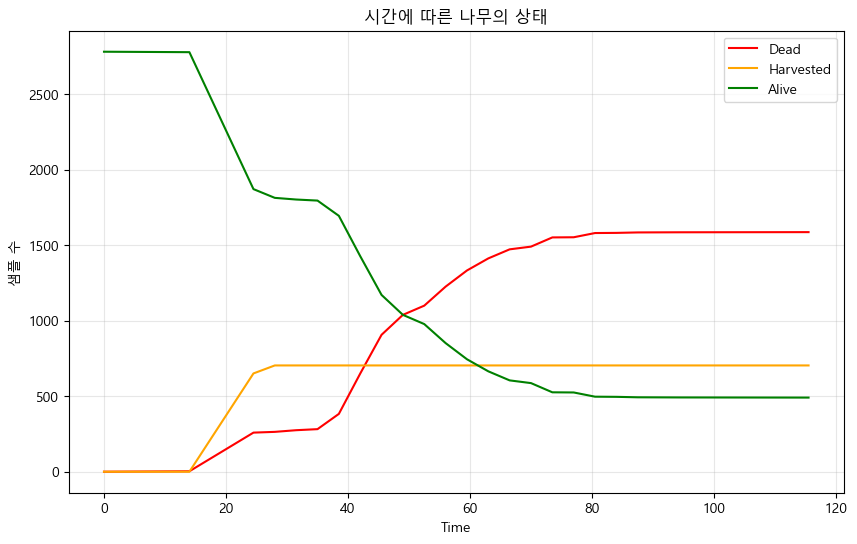

In [135]:
### 각 상태별 샘플 비율의 변화
dv.show_alive_about_time(decode)

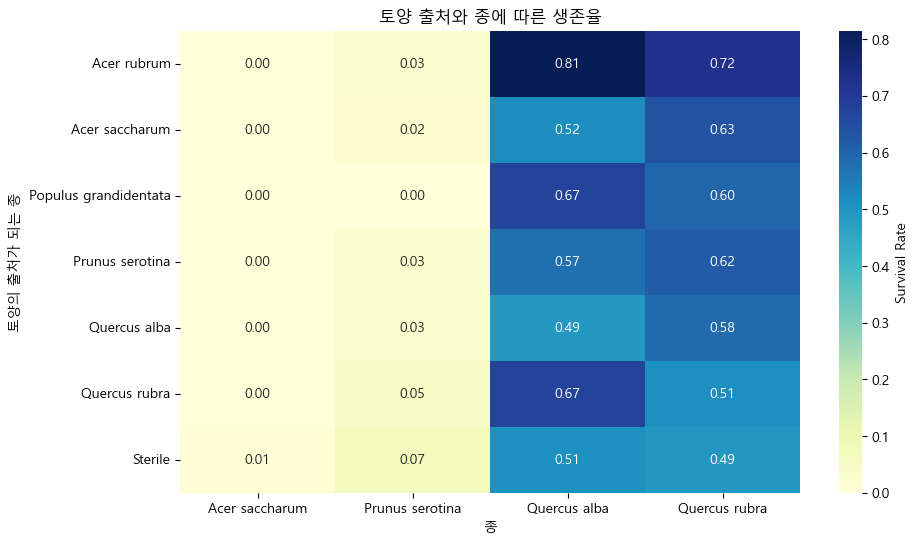

In [136]:
dv.show_survival_heatmap_by_soil(decode)

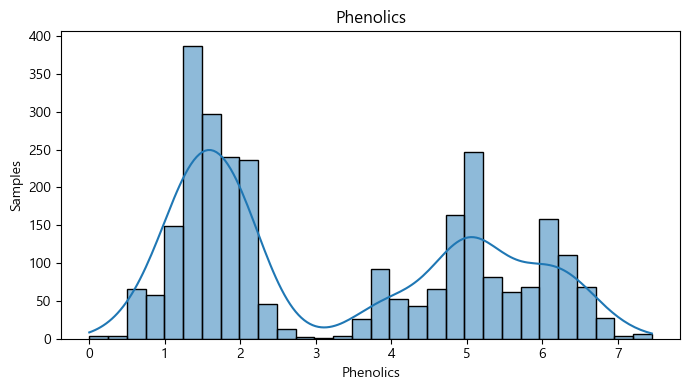

In [137]:
dv.show_chemical_histogram(decode, 'Phenolics')

<Figure size 600x600 with 0 Axes>

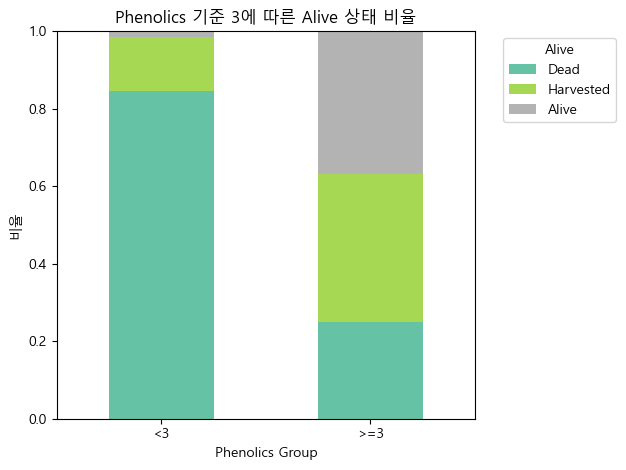

In [138]:
dv.show_survival_ratio_with_threshold(decode, 'Phenolics', 3)

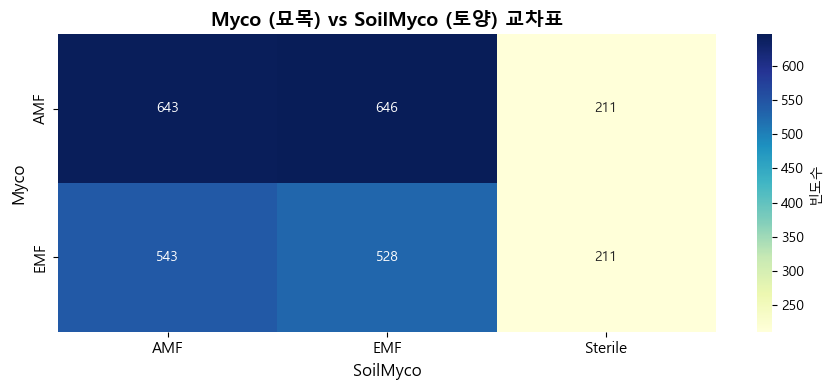

In [139]:
dv.show_hitmap_by_Myco(decode)

In [140]:
# dc.save_to_csv(encode)